<a href="https://colab.research.google.com/github/ninja197/BAexperiments/blob/main/MiniLM_finetuning_ner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install transformers datasets seqeval
! pip install git+https://github.com/huggingface/transformers.git
! pip install sentencepiece

     |████████████████████████████████| 4.0 MB 5.0 MB/s 
     |████████████████████████████████| 325 kB 48.3 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 77 kB 6.8 MB/s 
     |████████████████████████████████| 895 kB 38.9 MB/s 
     |████████████████████████████████| 596 kB 31.2 MB/s 
     |████████████████████████████████| 6.5 MB 40.1 MB/s 
     |████████████████████████████████| 212 kB 49.8 MB/s 
     |████████████████████████████████| 136 kB 50.7 MB/s 
     |████████████████████████████████| 1.1 MB 42.4 MB/s 
     |████████████████████████████████| 127 kB 50.0 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 144 kB 52.1 MB/s 
     |████████████████████████████████| 271 kB 54.1 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=c4a89f369d7f8f891dc864e5565ac02f95a6cc437abb1866364721d256a84784
  Stored in directory: /root/.cache/pip/whe

In [2]:
import torch
import transformers
import sentencepiece
import datasets
from datasets import load_dataset, load_metric

In [3]:
task = "ner" # Should be one of "ner", "pos" or "chunk"
model_checkpoint = "microsoft/Multilingual-MiniLM-L12-H384"
batch_size = 8

In [4]:
# prepare datasets

datasets = load_dataset("wikiann", "en")
train = datasets["train"]
test = datasets["test"]
validation = datasets["validation"]
label_list = datasets["train"].features[f"{task}_tags"].feature.names


Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset wikiann downloaded and prepared to /root/.cache/huggingface/datasets/wikiann/en/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
from transformers import AutoTokenizer

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
label_all_tokens = False

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

In [6]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [7]:
# preprocess datasets ->  applied on all the elements of all the splits in dataset
# training, validation and testing data will be preprocessed in one single command
tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

# add load_from_cache_file=False in map-call to force preprocessing to be apllied again (no cached filed)
# batched=True to encode the texts by batches together (advantage fast tokenizer -> multi threading)

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

In [8]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

#download pretrained model for fine-tuning, specify number of labels
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))

Downloading:   0%|          | 0.00/430 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/449M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at microsoft/Multilingual-MiniLM-L12-H384 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# define TrainingArguments
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
)

In [10]:
from transformers import DataCollatorForTokenClassification

# use data collector to batch the processed data together while applying padding to make them all the same size
data_collator = DataCollatorForTokenClassification(tokenizer)

In [11]:
# specify metric for computing from predictions -> commonly used to evaluate results on the CONLL dataset
metric = load_metric("seqeval")

example = datasets["train"][4]
labels = [label_list[i] for i in example[f"{task}_tags"]]
metric.compute(predictions=[labels], references=[labels])

{'PER': {'f1': 1.0, 'number': 3, 'precision': 1.0, 'recall': 1.0},
 'overall_accuracy': 1.0,
 'overall_f1': 1.0,
 'overall_precision': 1.0,
 'overall_recall': 1.0}

In [12]:
# post-processing on result of Trainer.evaluate (= tuple containing predictions and labels)
#   select the predicted index (with the maximum logit) for each token
#   convert it to its string label, ignore everywhere we set a label of -100

import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [13]:
# instantiate trainer

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [14]:
# finetune
trainer.train()

# evaluate on evaluation dataset
trainer.evaluate()

The following columns in the training set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: spans, ner_tags, langs, tokens. If spans, ner_tags, langs, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 20000
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12500


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.393900,0.364408,0.779933,0.792945,0.786385,0.910289
2,0.297900,0.316054,0.787354,0.802771,0.794988,0.912797
3,0.253900,0.286415,0.798292,0.819454,0.808735,0.919750
4,0.198900,0.289239,0.810567,0.826382,0.818398,0.923003
5,0.195500,0.288001,0.815676,0.828361,0.821970,0.923786


Saving model checkpoint to Multilingual-MiniLM-L12-H384-finetuned-ner/checkpoint-500
Configuration saved in Multilingual-MiniLM-L12-H384-finetuned-ner/checkpoint-500/config.json
Model weights saved in Multilingual-MiniLM-L12-H384-finetuned-ner/checkpoint-500/pytorch_model.bin
tokenizer config file saved in Multilingual-MiniLM-L12-H384-finetuned-ner/checkpoint-500/tokenizer_config.json
Special tokens file saved in Multilingual-MiniLM-L12-H384-finetuned-ner/checkpoint-500/special_tokens_map.json
Saving model checkpoint to Multilingual-MiniLM-L12-H384-finetuned-ner/checkpoint-1000
Configuration saved in Multilingual-MiniLM-L12-H384-finetuned-ner/checkpoint-1000/config.json
Model weights saved in Multilingual-MiniLM-L12-H384-finetuned-ner/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in Multilingual-MiniLM-L12-H384-finetuned-ner/checkpoint-1000/tokenizer_config.json
Special tokens file saved in Multilingual-MiniLM-L12-H384-finetuned-ner/checkpoint-1000/special_tokens_map.js

{'epoch': 5.0,
 'eval_accuracy': 0.9237856362372107,
 'eval_f1': 0.8219696969696969,
 'eval_loss': 0.28800079226493835,
 'eval_precision': 0.8156759014339412,
 'eval_recall': 0.8283613742400678,
 'eval_runtime': 28.5104,
 'eval_samples_per_second': 350.749,
 'eval_steps_per_second': 43.844}

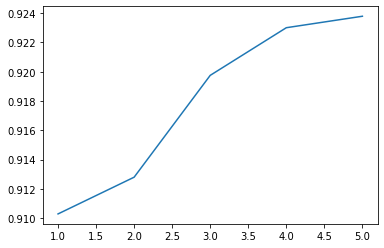

In [2]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot([1, 2, 3, 4, 5], [0.910289, 0.912797, 0.919750, 0.923003, 0.923786]);  # Plot some data on the axes.
